Plots winrate of latest KataGo checkpoints,
starting from b40-s11840M (aka cp505)
and going until networks from 2023-03-14
(a few months after adversarial-position-selfplay started).

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from IPython.core.display import HTML
from IPython.display import display
from sgf_parser import game_info
from statsmodels.stats.proportion import proportion_confint

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

### Parse data

In [3]:
df = utils.parse_sgfs(
    [
        "/nas/ucb/tony/go-attack/matches/cyclic-adv-s545m-vs-newer-katago-ckpts/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-try0/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-v32/",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.1",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.2",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.3.1",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.3.2",
        "/nas/ucb/k8/go-attack/match/tony-advft-v-kata/"
    ]
)
df["victim_net_type"] = df.victim_name.str.split("-").str[0]
df["victim_rows"] = (
    df.victim_name.str.split("-v").str[0].str.split("-d").str[-1].astype(int)
)
len(df), df.victim_visits.unique(), df.adv_name.unique()

(45756,
 array([200,   1,  32]),
 array(['adv-s545065216-v600-AMCTS', 'adv-s22887680-v600-AMCTS'],
       dtype=object))

In [4]:
# kata1-b60c320-s6729327872-d3057177418 is last checkpoint before
# adversarial training begins
ADV_TRAIN_ROW_START = 3057177418

# Latest - kata1-b40c256-s11840935168-d2898845681 
LATEST_STEPS = 11840935168

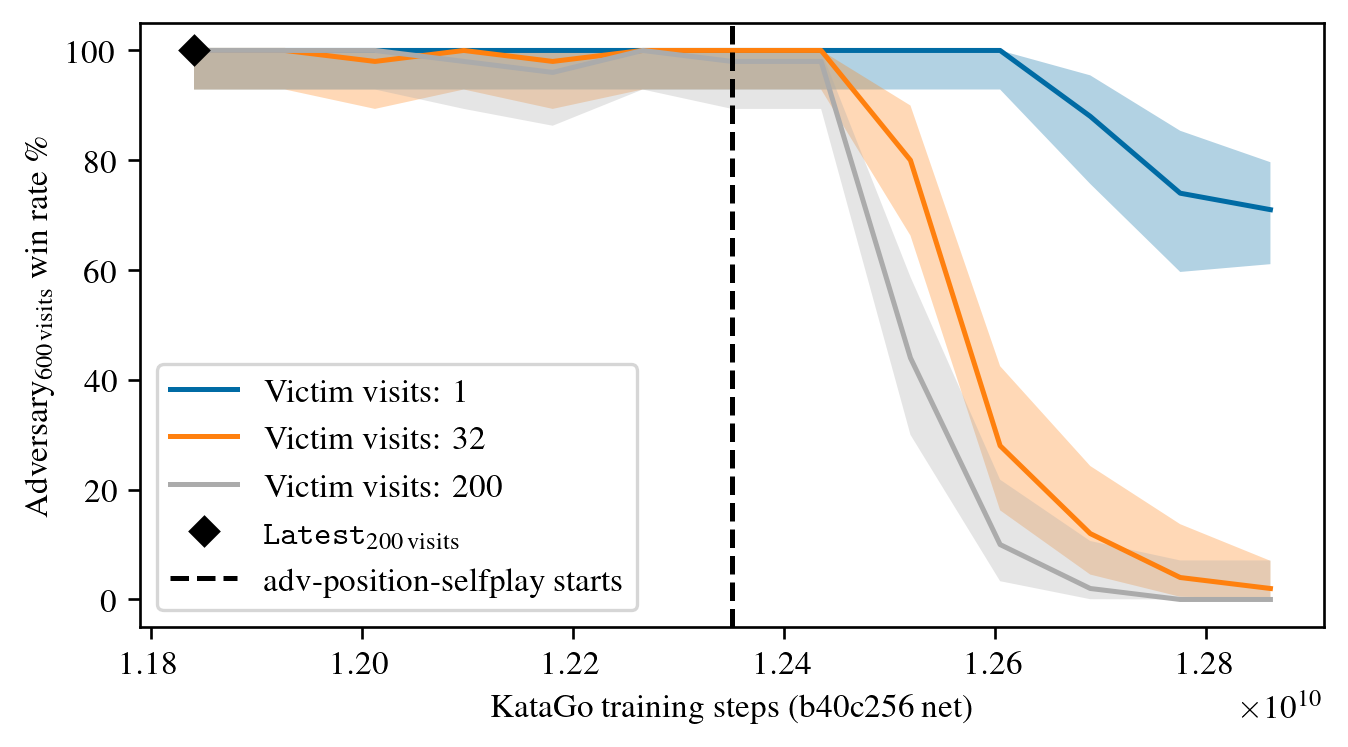

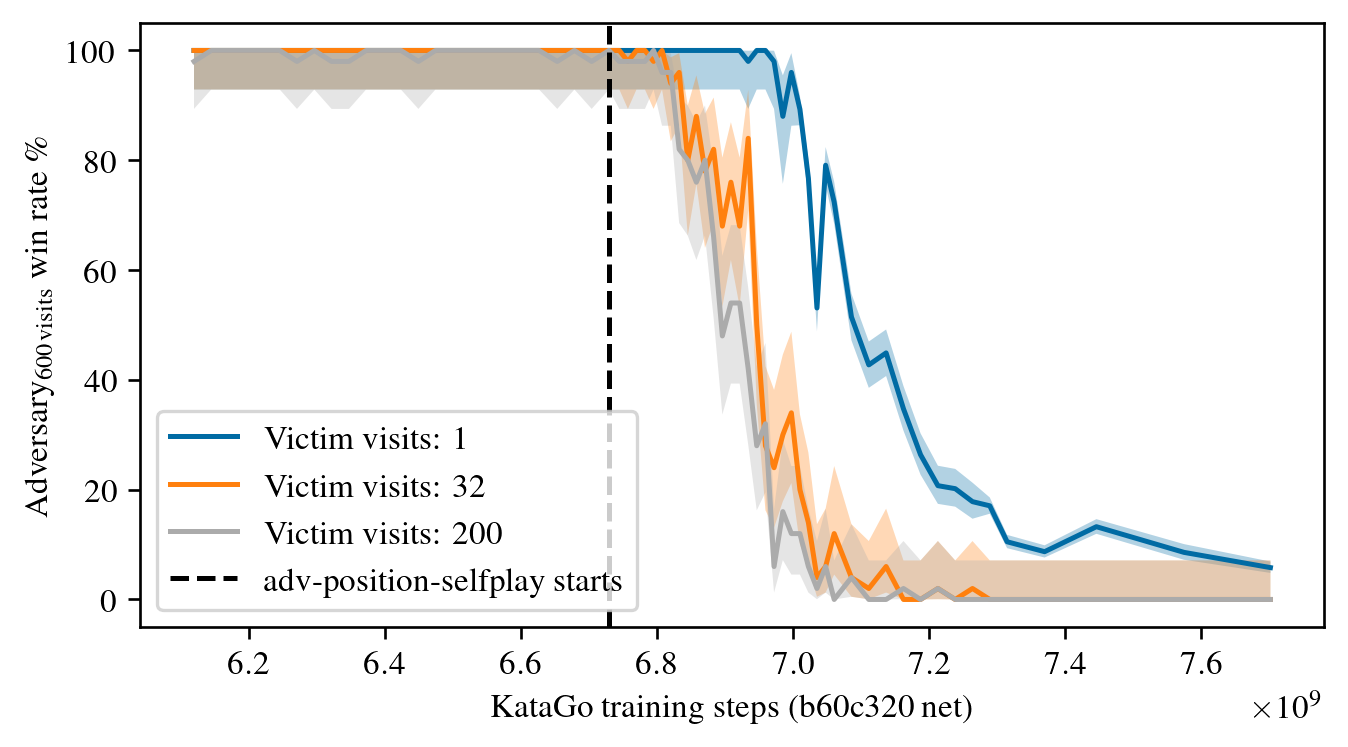

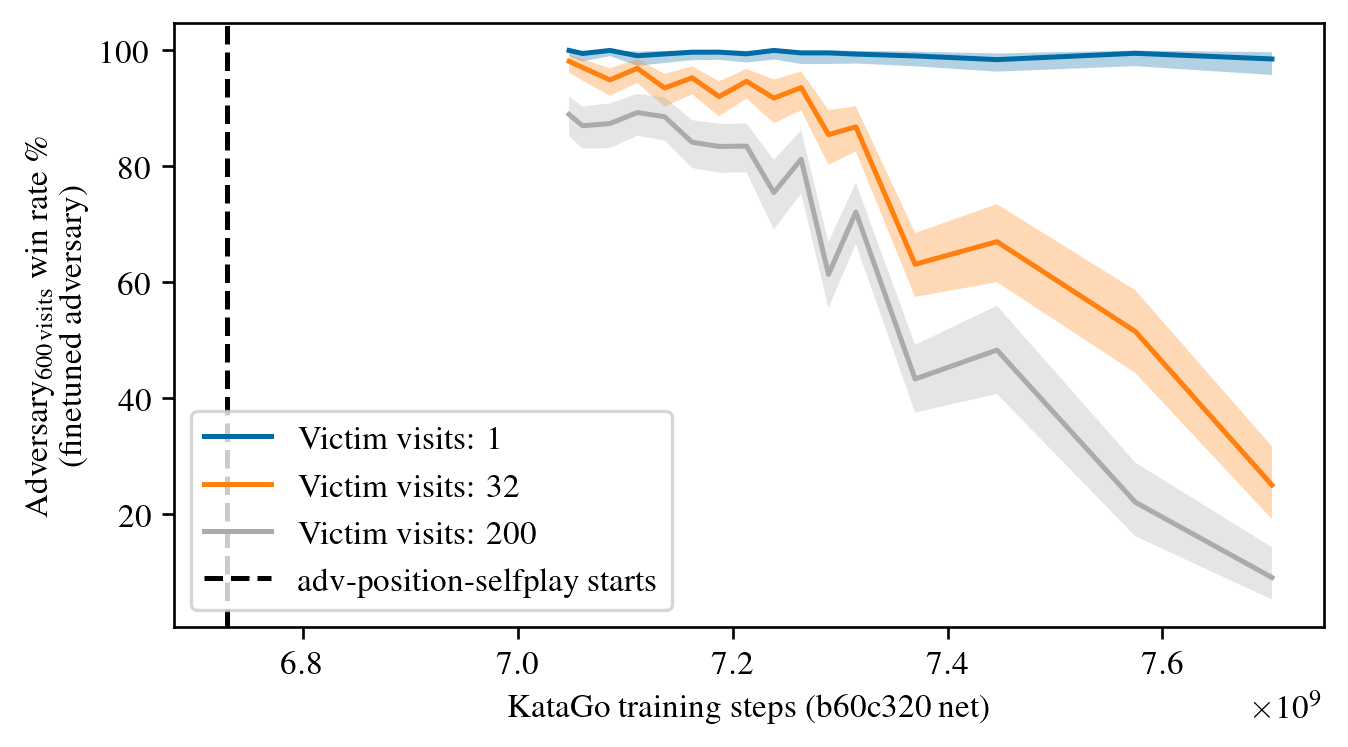

In [5]:
def generate_fancy_plots(adv_name: str, net_types: list[str]):
    ALPHA = 0.05
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for net_type in net_types:
        for i, vv in enumerate(sorted(df.victim_visits.unique())):
            sub_df = df.query(
                "&".join(
                    [
                        "victim_net_type == @net_type",
                        "victim_visits == @vv",
                        "adv_name == @adv_name",
                    ]
                )
            )
            mean_df = sub_df.groupby("victim_steps").adv_win.mean()

            (100 * mean_df).plot(label=f"Victim visits: {vv}", color=colors[i])

            # Compute Clopper-Pearson confidence intervals
            ci_df = sub_df.groupby("victim_steps").adv_win.apply(
                lambda x: proportion_confint(
                    x.sum(),
                    len(x),
                    alpha=ALPHA,
                    method="beta",
                )
            )
            ci_df = pd.DataFrame(
                ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
            )
            ci_df = 100 * ci_df
            plt.fill_between(
                mean_df.index,
                ci_df.lower,  # type: ignore
                ci_df.upper,  # type: ignore
                alpha=0.3,
                color=colors[i],
                edgecolor="none",
            )

            if vv == 200 and net_type == "b40c256":
                plt.plot(
                    LATEST_STEPS,
                    100 * sub_df.query("victim_steps == @LATEST_STEPS").adv_win.mean(),
                    "D",
                    label=r"\texttt{Latest}$_\mathrm{200\,visits}$",
                    color="black",
                )

        adv_training_start_steps = df.query(
            "victim_net_type == @net_type & victim_rows <= @ADV_TRAIN_ROW_START"
        ).victim_steps.max()
        plt.axvline(
            adv_training_start_steps,
            color="black",
            linestyle="--",
            label="adv-position-selfplay starts",
        )

        # Legend in lower left corner
        plt.legend(loc="lower left")
        plt.ylabel(
            r"Adversary$_\mathrm{600\,visits}$ win rate \%"
            + ("\n(finetuned adversary)" if "s22887680" in adv_name else "")
        )
        plt.xlabel(rf"KataGo training steps ({net_type} net)")
        plt.show()


generate_fancy_plots(
    adv_name="adv-s545065216-v600-AMCTS", net_types=["b40c256", "b60c320"]
)
generate_fancy_plots(adv_name="adv-s22887680-v600-AMCTS", net_types=["b60c320"])


### Study games

In [6]:
def display_link(link: str, text: str = "Link to game"):
    display(HTML(f'<a href="{link}">{text}</a>'))

In [7]:
sorted(df.query("victim_net_type == 'b60c320'").victim_steps.unique())[-5:]

[7314725888, 7369871872, 7445994752, 7574764800, 7701878528]

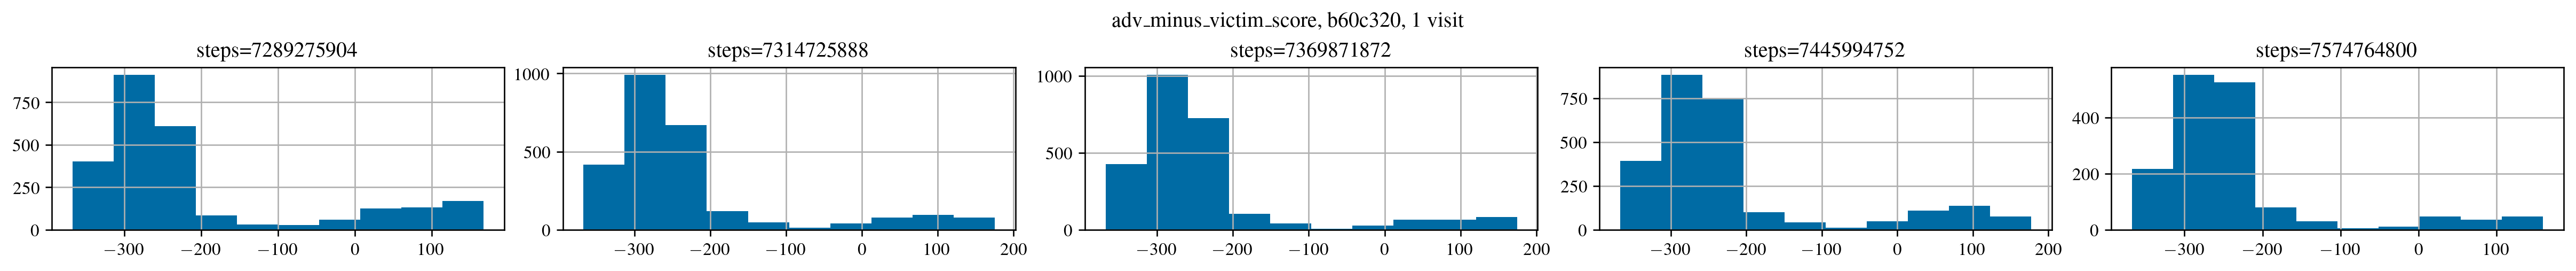

In [8]:
plt.figure(figsize=(20, 2))
plt.suptitle("adv_minus_victim_score, b60c320, 1 visit")
for i, steps in enumerate([7289275904, 7314725888, 7369871872, 7445994752, 7574764800]):
    plt.subplot(1, 5, i + 1)
    sub_df = df.query(
        "&".join(
            [
                "victim_net_type == 'b60c320'",
                "victim_steps == @steps",
                "victim_visits == 1",
                "adv_name == 'adv-s545065216-v600-AMCTS'",
            ]
        )
    )
    sub_df.adv_minus_victim_score.hist()
    plt.title(f"{steps=}")

In [9]:
sub_df = df.query(
    "&".join(
        [
            "victim_net_type == 'b60c320'",
            "victim_steps == 7574764800",
            "victim_visits == 1",
            "adv_name == 'adv-s545065216-v600-AMCTS'",
        ]
    )
)

print("Winning games")
for row in list(sub_df.query("adv_win").itertuples())[:5]:
    display_link(game_info.get_viz_link(row.sgf_path, row.sgf_line))

print("Losing games")
for row in list(sub_df.query("~adv_win").itertuples())[:5]:
    display_link(game_info.get_viz_link(row.sgf_path, row.sgf_line))

Winning games


Losing games
